In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import pandas as pd

In [ ]:
# Load the pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_resnet_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = resnet_model.predict(img_array)
    return features.flatten()

In [ ]:
# Path to dataset
main_path = '/content/drive/My Drive/projects_data/fyp/Categorized_images'
train_set_path = '/content/drive/My Drive/projects_data/fyp/Train Set'
test_set_path = '/content/drive/My Drive/projects_data/fyp/Test Set'
resnet_model_path = '/content/drive/My Drive/projects_data/fyp/resnet_model.keras'
dir_list = os.listdir(main_path)
print(dir_list)

['Bad', 'Neutral', 'Good', 'Very Bad', 'Very Good']


In [ ]:
labels = {'Very Bad': 4, 'Bad': 3, 'Neutral': 2, 'Good': 1, 'Very Good': 0}
image_list = {'Very Bad': [], 'Bad': [], 'Neutral': [], 'Good': [], 'Very Good': []}

In [ ]:
for dir_name in dir_list:
    files_in_dir = os.listdir(f"{main_path}/{dir_name}")
    image_list[dir_name].extend(files_in_dir)

for list_ in image_list:
    print(list_, len(image_list[list_]))

Very Bad 600
Bad 600
Neutral 600
Good 600
Very Good 600


In [ ]:
categories = ['Very Bad', 'Bad', 'Neutral', 'Good', 'Very Good']
for category in categories:
    os.makedirs(os.path.join(train_set_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_set_path, category), exist_ok=True)

In [ ]:
# Prepare data for feature extraction
def prepare_data_for_feature_extraction(folder_path):
    X_images = []
    y = []
    for category in categories:
        category_path = os.path.join(folder_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                features = extract_resnet_features(img_path)
                X_images.append(features)
                y.append(labels[category])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return np.array(X_images), np.array(y)

In [ ]:
# Extract features from the train and test sets
X_train, y_train = prepare_data_for_feature_extraction(train_set_path)
X_test, y_test = prepare_data_for_feature_extraction(test_set_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Save the ResNet50 model
resnet_model.save(resnet_model_path)

In [ ]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Train Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate the model
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.72


In [ ]:
# Save the RF model
with open('/content/drive/My Drive/projects_data/fyp/RN_model.pkl', 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=labels.keys(), columns=labels.keys())

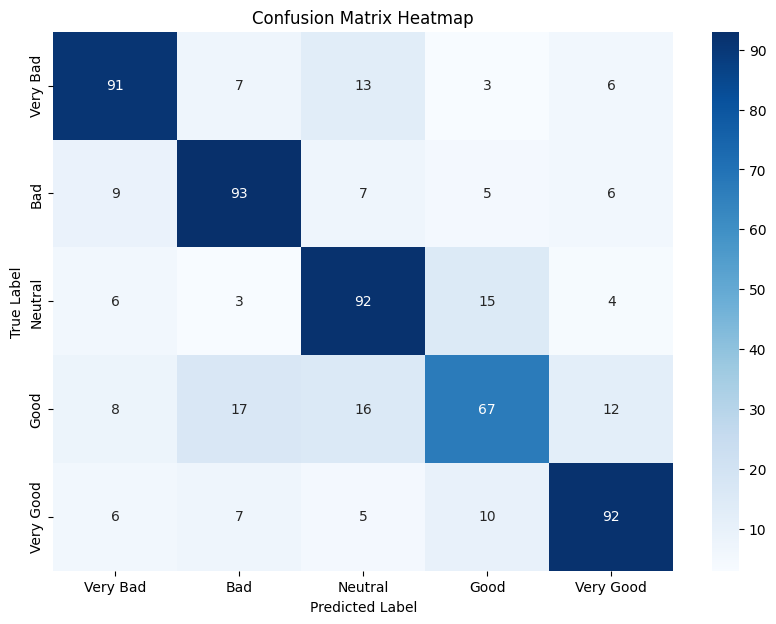

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=list(labels.keys()))

# Print the classification report
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

    Very Bad       0.76      0.76      0.76       120
         Bad       0.73      0.78      0.75       120
     Neutral       0.69      0.77      0.73       120
        Good       0.67      0.56      0.61       120
   Very Good       0.77      0.77      0.77       120

    accuracy                           0.73       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.72      0.72      0.72       600



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import numpy as np

# Load the trained model
model_path = '/content/drive/My Drive/projects_data/fyp/RN_model_2.pkl'
with open(model_path, 'rb') as file:
    RN_model_loaded = pickle.load(file)


Mounted at /content/drive


In [ ]:
# Load the ResNet50 model
resnet_model_path = '/content/drive/My Drive/projects_data/fyp/resnet_model.keras'
resnet_model = tf.keras.models.load_model(resnet_model_path)

In [ ]:
# Function to preprocess and extract features from a single image
def extract_resnet_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = resnet_model.predict(img_array)
    return features.flatten()

# Dictionary to map numerical labels back to category names
labels = {0: 'Very Good', 1: 'Good', 2: 'Neutral', 3: 'Bad', 4: 'Very Bad'}

# Path to a test image from the "Bad" category
test_image_path = '/content/drive/My Drive/projects_data/fyp/Test Set/Very Good/209.jpeg'

# Extract features from the test image
test_image_features = extract_resnet_features(test_image_path)

# Reshape the features to match the input shape expected by the Random Forest model
test_image_features = test_image_features.reshape(1, -1)

# Predict the label of the test image
predicted_label_index = RN_model_loaded.predict(test_image_features)[0]

# Get the predicted label name
predicted_label = labels[predicted_label_index]

print(f'Predicted Label: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Label: Very Good
